# Amazon Ratings Classifers with Textual Reviews
## COSC74 - Machine Learning & Statistical Data Analysis Project

This notebook processes the data and perform the machine learning tasks. A full write-up with results and interpretations will be submitted separately.

### 1. Objectives

### 1.1. Classifcation Tasks
The first part of this project uses different machine learning algorithms to categorize product ratings (from 1 to 5 stars) on Amazon based on reviews from the Amazon Product Reviews dataset. Our ultimate goal is to find the best algorithms and parameters for most accurate prediction of ratings, as measured by a range of metrics. The 5 classification tasks are: 
- Binary Classification Rating =1 vs ≥2
- Binary Classification Rating ≤2 vs ≥3
- Binary Classification Rating ≤3 vs ≥4
- Binary Classification Rating ≤4 vs =5
- Multiclass Classification for all ratings

### 1.2. K-Means Clustering
The second part of the project aims to use K-Means clustering to group observations by product type based on reviews.

### 2. Import Libraries and Data

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from warnings import simplefilter

warnings.filterwarnings('ignore')
simplefilter(action='ignore')

In [2]:
# Import data
df = pd.DataFrame(pd.read_csv("Training.csv"))

# Select relevant columns
data = df[['overall', 'reviewText','summary']]
data.head()

,overall,reviewText,summary
0,1,all of the reviews for this product are fake.,"All fake reviews, beware."
1,1,wrong part. our fault.,One Star
2,1,this wire set it really sucks!!!,One Star
3,1,"first use, it leaked instantly. even at 5 buck...",One Star
4,1,didn't fit,One Star


## 3. Data Pre-processing, Feature Selection, and Splitting

### 3.1. Check for missing data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29189 entries, 0 to 29188
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   overall     29189 non-null  int64 
 1   reviewText  29189 non-null  object
 2   summary     29184 non-null  object
dtypes: int64(1), object(2)
memory usage: 684.2+ KB


We can see that 5 observations have missing entries for 'summary.' We drop these entries from the dataset:

In [4]:
data.dropna(inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29184 entries, 0 to 29188
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   overall     29184 non-null  int64 
 1   reviewText  29184 non-null  object
 2   summary     29184 non-null  object
dtypes: int64(1), object(2)
memory usage: 912.0+ KB


### 3.2. Inspect Data Balance

In [5]:
# Isolate dataframe for overall ratings
tags = data['overall']

# Get count of each ratings
rating_counts = tags.value_counts(sort = False)
rating_counts

1    5956
2    5958
3    5862
4    5766
5    5642
Name: overall, dtype: int64

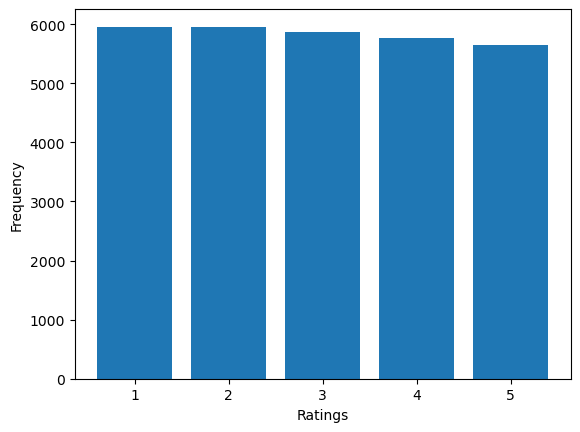

In [6]:
# Visualize
counts = rating_counts.values
ratings = [1,2,3,4,5]

plt.bar(ratings, counts);
plt.xlabel("Ratings");
plt.ylabel("Frequency");

We can see that our data is balance, with roughly similar number of observations for each ratings.

### 3.3. Pre-process Textual Data with TF-IDF Vectorizers

In order to convert 'reviewText' and 'summary' into meaningful numerical formats that can be passed into the models, we use TF-IDF Vectorizers. Simply speaking, TF-IDF uses the frequency of words in a document to determine how relevant and important those words are.    
   
   
The steps to pre-process reviewText and summary are:
- Convert all texts to lower case.
- Remove all punctuations.
- Fit and transform the data using TF-IDF vectorizer, eliminating English stop words like 'and','for', etc.


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
# Convert reviewText and summary to lower case
data.loc[:, 'reviewText'] = data['reviewText'].str.lower()
data.loc[:, 'summary'] = data['summary'].str.lower()

# Remove punctuations for reviewText and summary
data['reviewText']=data['reviewText'].str.replace('[^\w\s]','')
data['summary']=data['summary'].str.replace('[^\w\s]','')

data.head()

,overall,reviewText,summary
0,1,all of the reviews for this product are fake,all fake reviews beware
1,1,wrong part our fault,one star
2,1,this wire set it really sucks,one star
3,1,first use it leaked instantly even at 5 bucks ...,one star
4,1,didnt fit,one star


In [9]:
# Vectorize reviewText - select 6000 most relevant words
vectorizer1 = TfidfVectorizer(stop_words = 'english', min_df = 5, max_features = 6000)
vectorizedReview = vectorizer1.fit_transform(data['reviewText']).toarray()

In [10]:
# Vectorize summaryText - select 6000 most relevant words
vectorizer2 = TfidfVectorizer(stop_words = 'english', min_df = 5, max_features = 6000)
vectorizedSummary = vectorizer2.fit_transform(data['summary'].values.astype('U')).toarray()

### 3.3. Feature Selection

The **vectorizer** method will be used for each classification task to select the most revelant features for the task's target tags.

In [11]:
from sklearn.feature_selection import SelectKBest, f_classif

In [12]:
def feature_selector(vectorizedReview, vectorizedSummary, tags):
    selector = SelectKBest(score_func=f_classif, k = 1200)
    
    selectedReview = selector.fit_transform(vectorizedReview, tags)
    selectedSummary = selector.fit_transform(vectorizedSummary, tags)
    
    X = np.concatenate((selectedReview, selectedSummary), axis =1)
    
    return X

## 4. Classifcation Tasks

For the binary and multiclass classification tasks, I used the following training algorithms:
- Linear Logistic Regression (using liblinear solver)
- Perceptron
- Multinomial Naïve Bayes (MNB)


The algorithms were chosen based on two main criteria: performance and speed. While other algorithms such as SVM or KNN might perform better than the chosen algorithms, they take a long time (up to 10 hours) to tune hyperparameters for using GridSearchCV. As this project is constrained by time, the three algorithms above were chosen to ensure fast and time-saving hyperparameter tuning. 


In [13]:
# Import libraries
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.metrics import RocCurveDisplay, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

**Methods for hyperparameter tuning:**

In [14]:
def model_helper(model_name):
    parameters = []
    model = None
    
    if model_name == "logistic":
        parameters = [{'penalty': ['l1','l2', 'none'],
                       'C': [100, 10, 1.0, 0.1],
                       'max_iter': [500, 1000, 5000]}]
        model = LogisticRegression(solver = "liblinear")
        
    elif model_name == "perceptron":
        parameters = [{'penalty': ['l2','l1', 'elasticnet'],
                       'l1_ratio': [0, 0.1, 0.5, 1],
                       'max_iter': [500, 1000]}]
        model = Perceptron()
    
    else:
        parameters = [{'alpha': [1.0e-10, 1, 10, 20, 50, 100]}]
        model = MultinomialNB()
        
    return parameters, model

In [15]:
def hyperparameter_tuning(model_name, X, y):
    
    parameters, model = model_helper(model_name)
    
    # Hyper-parameter tuning using 5-fold cross-validation and f1-macro to evaluate best model
    clf = GridSearchCV(model, param_grid = parameters, cv = 5, verbose = 1, n_jobs = -1, scoring = 'f1_macro')
    best_clf = clf.fit(X, y)
    
    # Get best model
    best_model = best_clf.best_estimator_
    best_cv = best_clf.best_score_
    
    # Print mean cross-validation score
    cv_scores = pd.DataFrame(best_clf.cv_results_)
    mean_cv_score = cv_scores.loc[:, 'mean_test_score'].mean()
    
    # Print results of tuning
    print("---------------------------")
    print("Best model and hyperparameters:", best_model)
    print("Best model's 5-fold cross-validation f1 macro:", best_cv)
    print("Mean 5-fold cross-validation F1 score:", mean_cv_score)
    print("---------------------------")
    
    return best_model, best_cv

**Method for model evaluation:**

In [16]:
def model_evaluation(model, X_train, X_test, y_train, y_test, multiclass = False):
    # Fit model to training data
    model.fit(X_train, y_train)
    
    # Predict label for test set
    y_predicted = model.predict(X_test)
    
    f1 = f1_score(y_test, y_predicted, average = 'macro')
    accuracy = accuracy_score(y_test, y_predicted)
    
    # Print evaluation metrics
    print("---------------------------")
    print("F1 score from testing:", f1)
    print("Accuracy from testing:", accuracy)
    print("---------------------------")
    print("ROC Curve and Confusion Matrix")
    
    # Visualize ROC Curve and Confusion Matrix
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # ROC Curve for binary vs multiclass
    if multiclass == False:
        roc_display = RocCurveDisplay.from_predictions(y_test, y_predicted, ax=axes[0]);
        roc_score = roc_auc_score(y_test, y_predicted)

    else:
        roc_score = plot_roc_curve(y_test, y_predicted, model, ax=axes[0])

    confusion_display = ConfusionMatrixDisplay.from_predictions(y_test, y_predicted, ax=axes[1])
    
    axes[0].set_title("ROC Curve");
    axes[1].set_title("Confusion Matrix");
    
    plt.show();
    
    return f1, accuracy, roc_score

### Method for comparing different models' performance in each task

In [17]:
def compare_table(data, task_number):
    column_titles = ['Model', 'Cross-validation F1', 'Test F1', 'Accuracy', 'AUC-ROC']
    data = np.array(data)
    
    for i in range(1, 5):
        for j in range(0,3):
            data[j, i] = data[j, i][:5]

    fig, ax = plt.subplots(figsize = (12,2))
    ax.axis('off')
    
    colWidths = [0.6, 0.2, 0.1,0.1,0.1]
    table = ax.table(cellText=data, colLabels=column_titles, cellLoc='center', loc='center', colWidths = colWidths)
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)  # Set the font size for the entire table

    table.scale(1, 2)
    
    plt.suptitle("Model Performances - Task " + str(task_number))
    plt.show()

### 4.1. Classifer Task 1: Rating =1 vs ≥2

#### Prepare data

In [18]:
# 'overall' = 1 labeled as 0, 'overall' > 1 labelled as 1
y1 = tags.replace([1,2,3,4,5], [0,1,1,1,1]).to_numpy()

In [19]:
# Select features 
X1 = feature_selector(vectorizedReview, vectorizedSummary, y1)

# Split data
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, train_size = 0.8)

In [20]:
compare_data_1 = []

#### Logistic Regression

In [21]:
# Hyperparamter tuning
best_log1, best_cv_log1 = hyperparameter_tuning("logistic", X1, y1)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
---------------------------
Best model and hyperparameters: LogisticRegression(C=10, max_iter=500, solver='liblinear')
Best model's 5-fold cross-validation f1 macro: 0.7799894837534609
Mean 5-fold cross-validation F1 score: 0.7419887546454959
---------------------------


---------------------------
F1 score from testing: 0.8128703187579999
Accuracy from testing: 0.8893267089258181
---------------------------
ROC Curve and Confusion Matrix


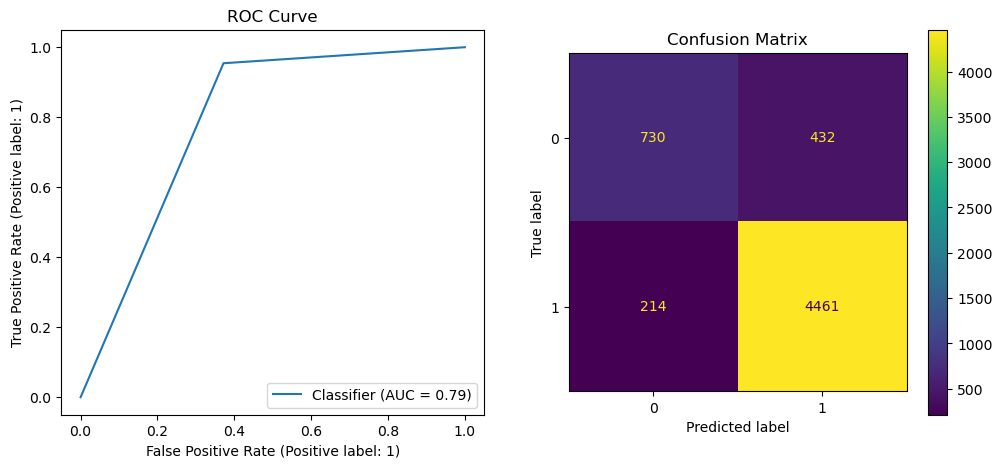

In [22]:
# Evaluation with train set and test sets
f1_log1, accuracy_log1, roc_score_log1 = model_evaluation(best_log1, X1_train, X1_test, y1_train, y1_test)

In [23]:
compare_data_1.append([str(best_log1), best_cv_log1, f1_log1, accuracy_log1, roc_score_log1])

#### Perceptron

In [24]:
# Hyperparamter tuning
best_perc1, best_cv_perc1 = hyperparameter_tuning("perceptron", X1, y1)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
---------------------------
Best model and hyperparameters: Perceptron(l1_ratio=0, max_iter=500, penalty='l2')
Best model's 5-fold cross-validation f1 macro: 0.6925989295386763
Mean 5-fold cross-validation F1 score: 0.684332713418783
---------------------------


---------------------------
F1 score from testing: 0.7180869769077483
Accuracy from testing: 0.7781394551995888
---------------------------
ROC Curve and Confusion Matrix


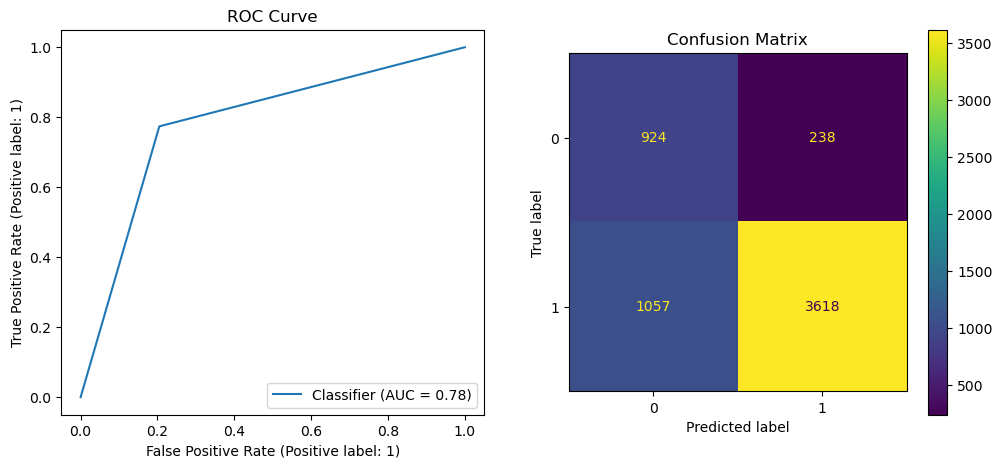

In [25]:
# Evaluation with train set and test sets
f1_perc1, accuracy_perc1, roc_score_perc1 = model_evaluation(best_perc1, X1_train, X1_test, y1_train, y1_test)

In [26]:
compare_data_1.append([str(best_perc1), best_cv_perc1, f1_perc1, accuracy_perc1, roc_score_perc1])

#### Multinomial Naive Bayes

In [27]:
# Hyperparamter tuning
best_nb1, best_cv_nb1 = hyperparameter_tuning("nb", X1, y1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
---------------------------
Best model and hyperparameters: MultinomialNB(alpha=1e-10)
Best model's 5-fold cross-validation f1 macro: 0.7672361886435646
Mean 5-fold cross-validation F1 score: 0.6595449109074901
---------------------------


---------------------------
F1 score from testing: 0.7908652780590864
Accuracy from testing: 0.8829878362172349
---------------------------
ROC Curve and Confusion Matrix


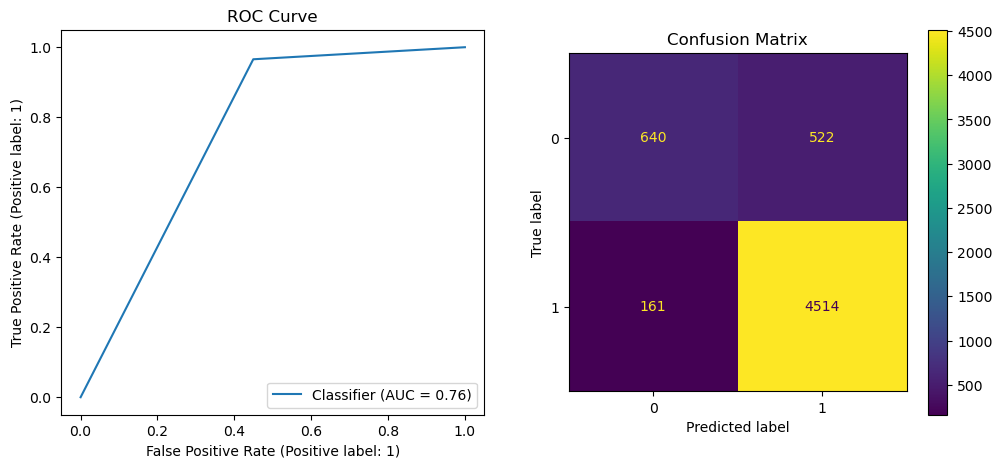

In [28]:
# Evaluation with train set and test sets
f1_nb1, accuracy_nb1, roc_score_nb1 = model_evaluation(best_nb1, X1_train, X1_test, y1_train, y1_test)

In [29]:
compare_data_1.append([str(best_nb1), best_cv_nb1, f1_nb1, accuracy_nb1, roc_score_nb1])

#### Compare performance

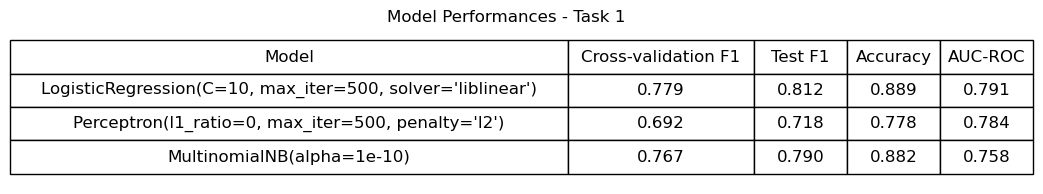

In [30]:
compare_table(compare_data_1, 1)

The top performers are Logistic Regression and Multinomial Naive Bayes, which yield pretty similar results.

### 4.2. Classifer Task 2: Rating ≤2 vs ≥3

#### Prepare data

In [31]:
# 'overall' ≤2 labeled as 0, 'overall' ≥3 labelled as 1
y2 = tags.replace([1,2,3,4,5], [0,0,1,1,1]).to_numpy()

In [32]:
# Select features 
X2 = feature_selector(vectorizedReview, vectorizedSummary, y2)

# Split data
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, train_size = 0.8)

In [33]:
compare_data_2 = []

#### Logistic Regression

In [34]:
# Hyperparamter tuning
best_log2, best_cv_log2 = hyperparameter_tuning("logistic", X2, y2)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
---------------------------
Best model and hyperparameters: LogisticRegression(C=10, max_iter=500, solver='liblinear')
Best model's 5-fold cross-validation f1 macro: 0.7891856460982313
Mean 5-fold cross-validation F1 score: 0.7762910071208012
---------------------------


---------------------------
F1 score from testing: 0.8048672687324261
Accuracy from testing: 0.813945519958883
---------------------------
ROC Curve and Confusion Matrix


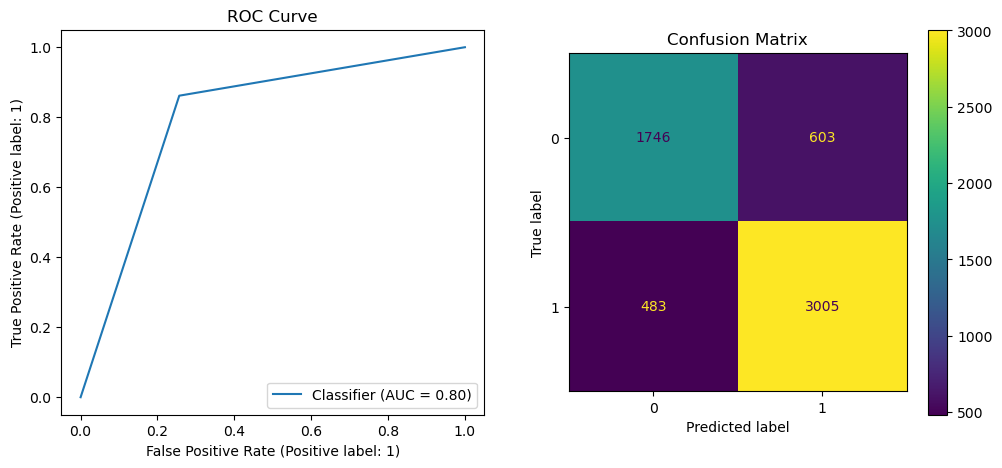

In [35]:
# Evaluation with train set and test sets
f1_log2, accuracy_log2, roc_score_log2 = model_evaluation(best_log2, X2_train, X2_test, y2_train, y2_test)

In [36]:
compare_data_2.append([str(best_log2), best_cv_log2, f1_log2, accuracy_log2, roc_score_log2])

#### Perceptron

In [37]:
# Hyperparamter tuning
best_perc2, best_cv_perc2 = hyperparameter_tuning("perceptron", X2, y2)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
---------------------------
Best model and hyperparameters: Perceptron(l1_ratio=0.5, max_iter=500, penalty='elasticnet')
Best model's 5-fold cross-validation f1 macro: 0.6743436208685415
Mean 5-fold cross-validation F1 score: 0.6545507674444394
---------------------------


---------------------------
F1 score from testing: 0.5725957470669184
Accuracy from testing: 0.6796299468905259
---------------------------
ROC Curve and Confusion Matrix


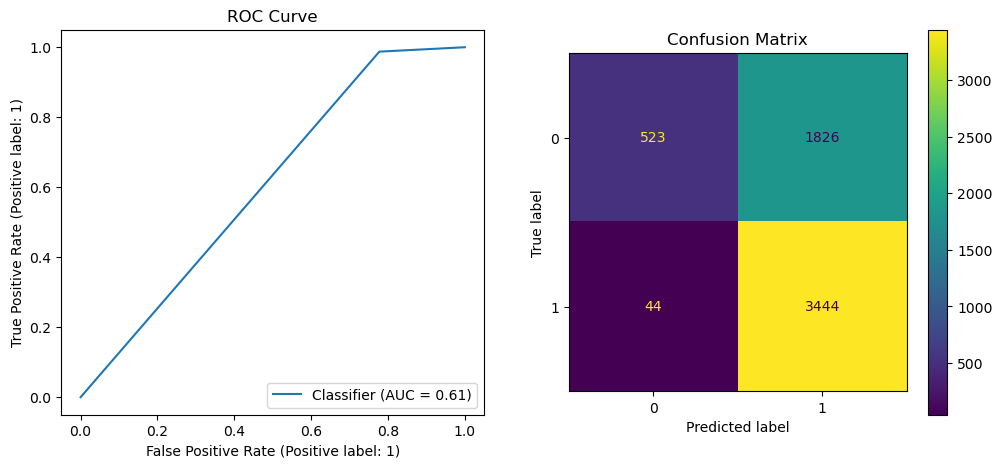

In [38]:
# Evaluation with train set and test sets
f1_perc2, accuracy_perc2, roc_score_perc2 = model_evaluation(best_perc2, X2_train, X2_test, y2_train, y2_test)

In [39]:
compare_data_2.append([str(best_perc2), best_cv_perc2, f1_perc2, accuracy_perc2, roc_score_perc2])

#### Multinomial Naive Bayes

In [40]:
# Hyperparamter tuning
best_nb2, best_cv_nb2 = hyperparameter_tuning("nb", X2, y2)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
---------------------------
Best model and hyperparameters: MultinomialNB(alpha=1)
Best model's 5-fold cross-validation f1 macro: 0.787051742840048
Mean 5-fold cross-validation F1 score: 0.7039119212864292
---------------------------


---------------------------
F1 score from testing: 0.792060965869559
Accuracy from testing: 0.8062360801781737
---------------------------
ROC Curve and Confusion Matrix


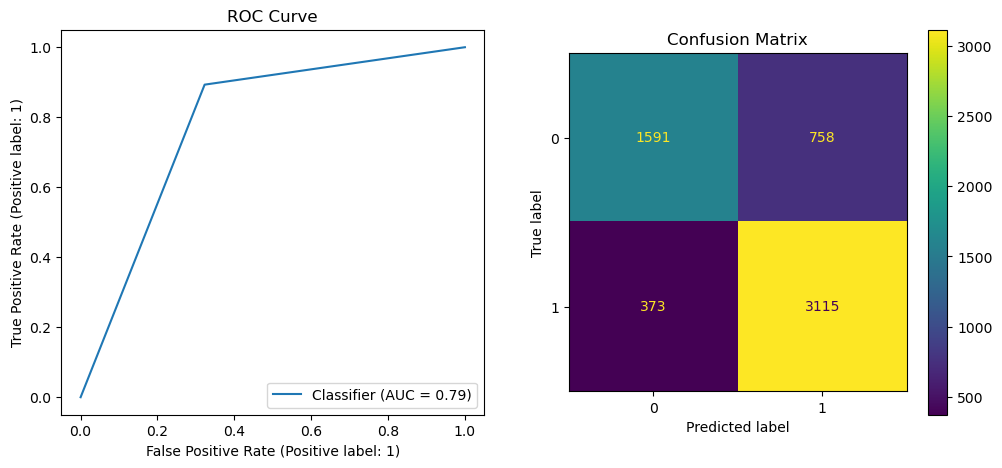

In [41]:
# Evaluation with train set and test sets
f1_nb2, accuracy_nb2, roc_score_nb2 = model_evaluation(best_nb2, X2_train, X2_test, y2_train, y2_test)

In [42]:
compare_data_2.append([str(best_nb2), best_cv_nb2, f1_nb2, accuracy_nb2, roc_score_nb2])

#### Compare performance

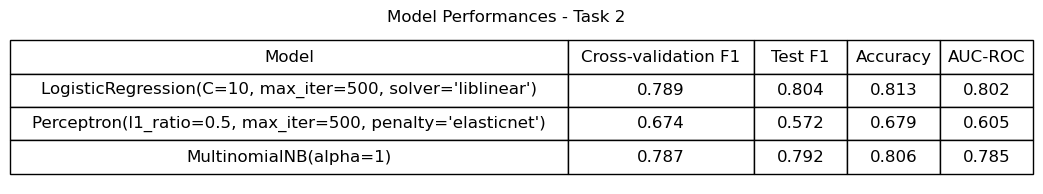

In [43]:
compare_table(compare_data_2, 2)

The top performers are Logistic Regression and Multinomial Naive Bayes, which yield pretty similar performance.

### 4.3. Classifer Task 3: Rating ≤3 vs ≥4

#### Prepare data

In [44]:
# 'overall' ≤3 labeled as 0, 'overall' ≥4 labelled as 1
y3 = tags.replace([1,2,3,4,5], [0,0,0,1,1]).to_numpy()

In [45]:
# Select features 
X3 = feature_selector(vectorizedReview, vectorizedSummary, y3)

# Split data
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.2, train_size = 0.8)

In [46]:
compare_data_3 = []

#### Logistic Regression

In [47]:
# Hyperparamter tuning
best_log3, best_cv_log3 = hyperparameter_tuning("logistic", X3, y3)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
---------------------------
Best model and hyperparameters: LogisticRegression(C=10, max_iter=500, solver='liblinear')
Best model's 5-fold cross-validation f1 macro: 0.8006595634062288
Mean 5-fold cross-validation F1 score: 0.7728181456545812
---------------------------


---------------------------
F1 score from testing: 0.8163739085320887
Accuracy from testing: 0.8261093027240021
---------------------------
ROC Curve and Confusion Matrix


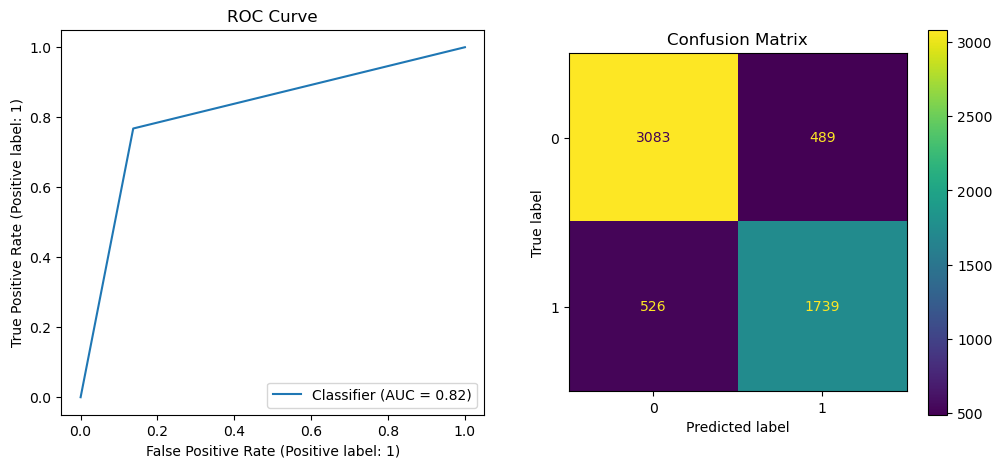

In [48]:
# Evaluation with train set and test sets
f1_log3, accuracy_log3, roc_score_log3 = model_evaluation(best_log3, X3_train, X3_test, y3_train, y3_test)

In [49]:
compare_data_3.append([str(best_log3), best_cv_log3, f1_log3, accuracy_log3, roc_score_log3])

#### Perceptron

In [50]:
# Hyperparamter tuning
best_perc3, best_cv_perc3 = hyperparameter_tuning("perceptron", X3, y3)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
---------------------------
Best model and hyperparameters: Perceptron(l1_ratio=0.5, max_iter=500, penalty='elasticnet')
Best model's 5-fold cross-validation f1 macro: 0.6941707894356113
Mean 5-fold cross-validation F1 score: 0.6215002998404727
---------------------------


---------------------------
F1 score from testing: 0.6192354702263239
Accuracy from testing: 0.7070412883330478
---------------------------
ROC Curve and Confusion Matrix


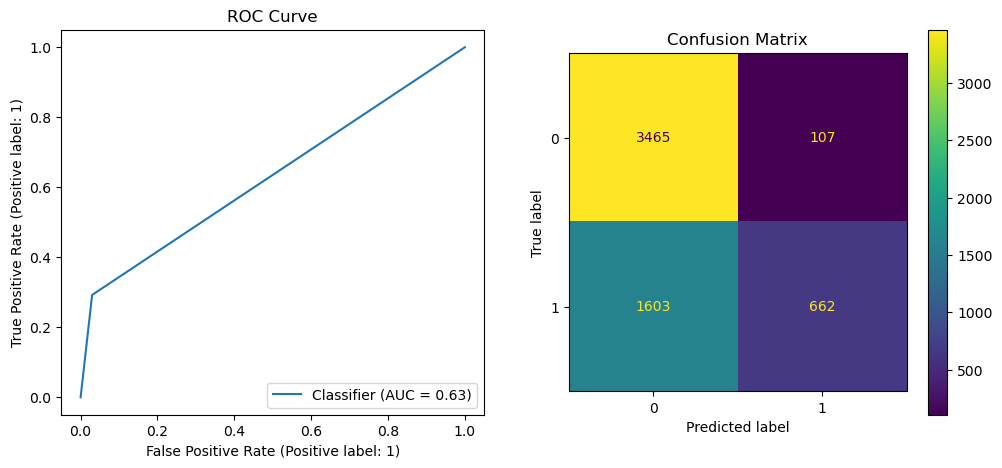

In [51]:
# Evaluation with train set and test sets
f1_perc3, accuracy_perc3, roc_score_perc3 = model_evaluation(best_perc3, X3_train, X3_test, y3_train, y3_test)

In [52]:
compare_data_3.append([str(best_perc3), best_cv_perc3, f1_perc3, accuracy_perc3, roc_score_perc3])

#### Multinomial Naive Bayes

In [53]:
# Hyperparamter tuning
best_nb3, best_cv_nb3 = hyperparameter_tuning("nb", X3, y3)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
---------------------------
Best model and hyperparameters: MultinomialNB(alpha=1)
Best model's 5-fold cross-validation f1 macro: 0.7941618955719745
Mean 5-fold cross-validation F1 score: 0.7099461679777628
---------------------------


---------------------------
F1 score from testing: 0.8045543734434845
Accuracy from testing: 0.8158300496830564
---------------------------
ROC Curve and Confusion Matrix


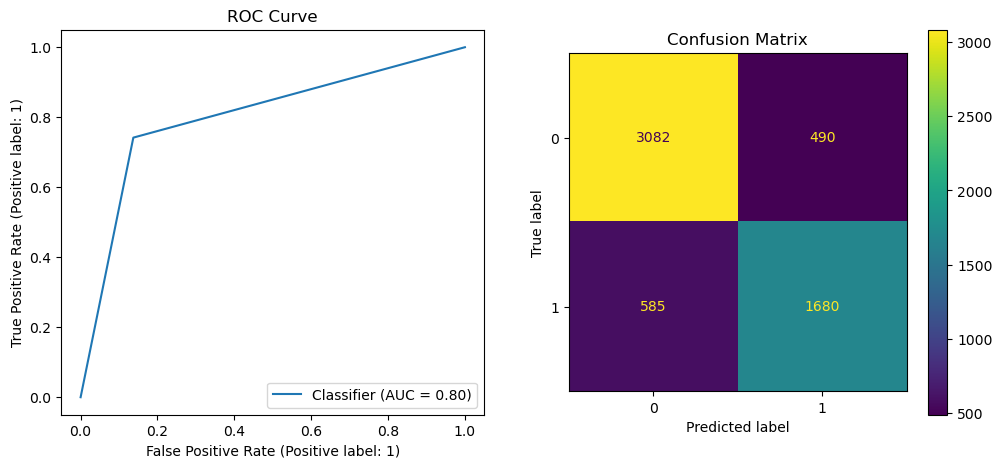

In [54]:
# Evaluation with train set and test sets
f1_nb3, accuracy_nb3, roc_score_nb3 = model_evaluation(best_nb3, X3_train, X3_test, y3_train, y3_test)

In [55]:
compare_data_3.append([str(best_nb3), best_cv_nb3, f1_nb3, accuracy_nb3, roc_score_nb3])

#### Compare performance

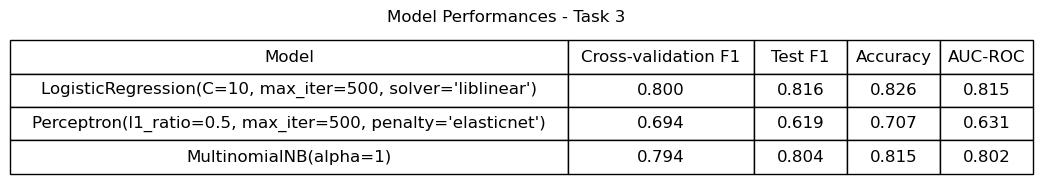

In [56]:
compare_table(compare_data_3, 3)

The top performers are Logistic Regression and Multinomial Naive Bayes, which yield pretty similar performance. Logistic Regression slightly outperforms MNB.

### 4.4. Classifer Task 4: Rating ≤4 vs =5

#### Prepare data

In [57]:
# 'overall' ≤4 labeled as 0, 'overall' =4 labelled as 1
y4 = tags.replace([1,2,3,4,5], [0,0,0,0,1]).to_numpy()

In [58]:
# Select features 
X4 = feature_selector(vectorizedReview, vectorizedSummary, y4)

# Split data
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = 0.2, train_size = 0.8)

In [59]:
compare_data_4 = []

#### Logistic Regression

In [60]:
# Hyperparamter tuning
best_log4, best_cv_log4 = hyperparameter_tuning("logistic", X4, y4)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
---------------------------
Best model and hyperparameters: LogisticRegression(C=10, max_iter=500, solver='liblinear')
Best model's 5-fold cross-validation f1 macro: 0.7458915133957964
Mean 5-fold cross-validation F1 score: 0.6995534461966857
---------------------------


---------------------------
F1 score from testing: 0.7657034859213852
Accuracy from testing: 0.8701387699160528
---------------------------
ROC Curve and Confusion Matrix


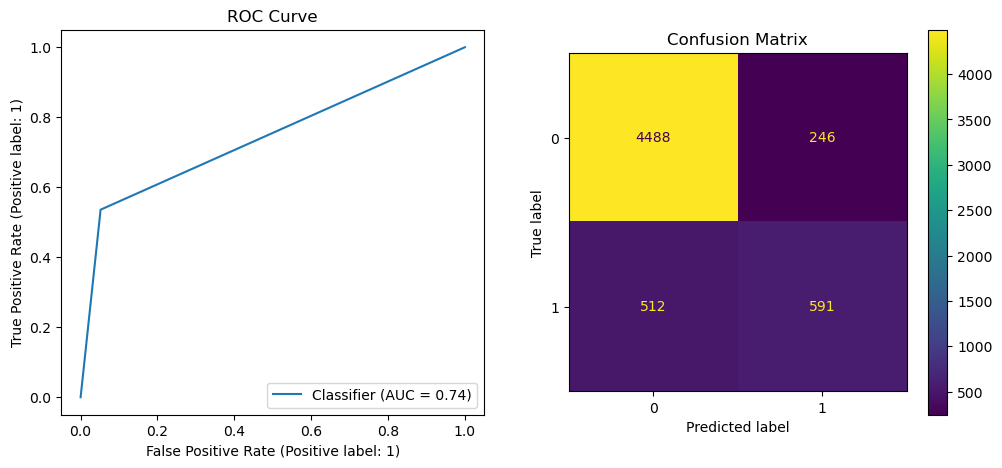

In [61]:
# Evaluation with train set and test sets
f1_log4, accuracy_log4, roc_score_log4 = model_evaluation(best_log4, X4_train, X4_test, y4_train, y4_test)

In [62]:
compare_data_4.append([str(best_log4), best_cv_log4, f1_log4, accuracy_log4, roc_score_log4])

#### Perceptron

In [63]:
# Hyperparamter tuning
best_perc4, best_cv_perc4 = hyperparameter_tuning("perceptron", X4, y4)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
---------------------------
Best model and hyperparameters: Perceptron(l1_ratio=0, max_iter=500, penalty='l2')
Best model's 5-fold cross-validation f1 macro: 0.6675894205952599
Mean 5-fold cross-validation F1 score: 0.629293994126488
---------------------------


---------------------------
F1 score from testing: 0.6479321180942639
Accuracy from testing: 0.6974473188281651
---------------------------
ROC Curve and Confusion Matrix


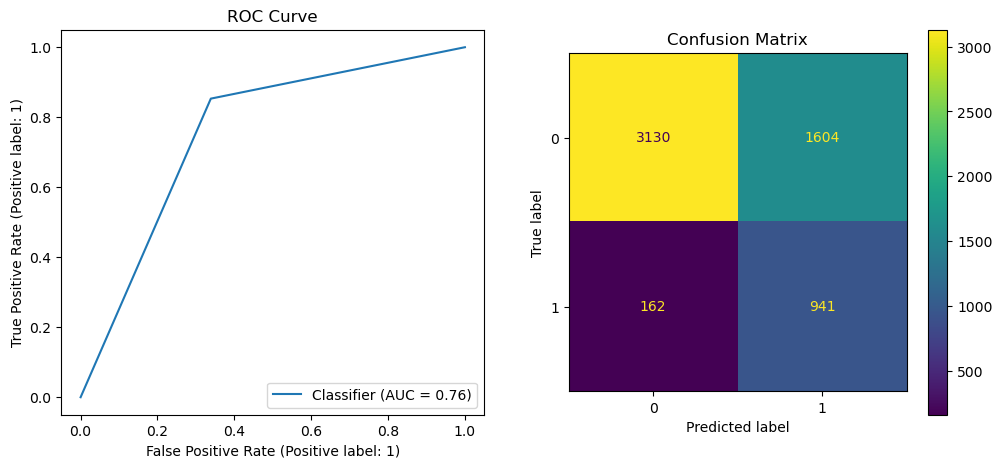

In [64]:
# Evaluation with train set and test sets
f1_perc4, accuracy_perc4, roc_score_perc4 = model_evaluation(best_perc4, X4_train, X4_test, y4_train, y4_test)

In [65]:
compare_data_4.append([str(best_perc4), best_cv_perc4, f1_perc4, accuracy_perc4, roc_score_perc4])

#### Multinomial Naive Bayes

In [66]:
# Hyperparamter tuning
best_nb4, best_cv_nb4 = hyperparameter_tuning("nb", X4, y4)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
---------------------------
Best model and hyperparameters: MultinomialNB(alpha=1e-10)
Best model's 5-fold cross-validation f1 macro: 0.712161645110753
Mean 5-fold cross-validation F1 score: 0.5390456390101561
---------------------------


---------------------------
F1 score from testing: 0.7350401047153783
Accuracy from testing: 0.8655131060476272
---------------------------
ROC Curve and Confusion Matrix


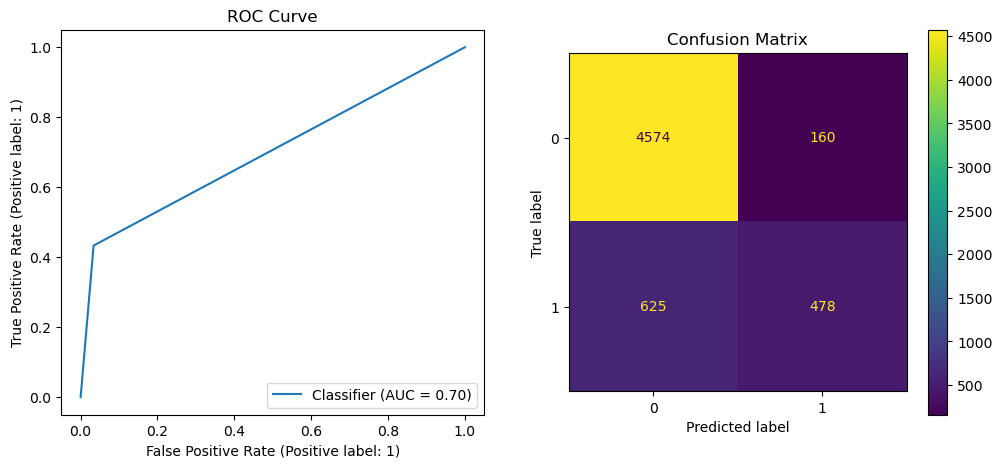

In [67]:
# Evaluation with train set and test sets
f1_nb4, accuracy_nb4, roc_score_nb4 = model_evaluation(best_nb4, X4_train, X4_test, y4_train, y4_test)

In [68]:
compare_data_4.append([str(best_nb4), best_cv_nb4, f1_nb4, accuracy_nb4, roc_score_nb4])

#### Compare performance

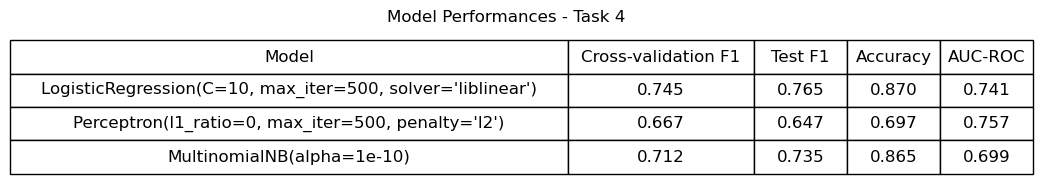

In [69]:
compare_table(compare_data_4, 4)

The top performers are Logistic Regression and Multinomial Naive Bayes, with Logistic Regression slightly outperforming the other.

### 4.5. Multiclass Classifier

#### Prepare data

In [70]:
# Select features 
X5 = feature_selector(vectorizedReview, vectorizedSummary, tags)

# Split data
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, tags, test_size = 0.2, train_size = 0.8)

In [71]:
compare_data_5 = []

#### Multiclass ROC Curve

In [72]:
from itertools import cycle
from sklearn.preprocessing import label_binarize

Function to plot multiclass ROC Curve:

In [73]:
def plot_roc_curve(y_test, y_pred, model, ax):
    n_class = 5
    classes=[1,2,3,4,5]
    y_test_binarized = label_binarize(y_test, classes = classes )
    y_pred_binarized = label_binarize(y_pred, classes = classes)
        
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Compute ROC curve and ROC area for each class and plot them
    
    fig = ax.get_figure()
    
    for i in range(n_class):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        ax.plot(fpr[i], tpr[i], linestyle = '--', label = '%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))
    
    # Find micro average to get average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_binarized.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    roc_average = roc_auc["micro"]
    
    # Plot average curve using micro average 
    ax.plot(fpr["micro"], tpr["micro"], label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]), color="deeppink", linestyle=":", linewidth=4,)
    
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC curve) - " + str(model))
    ax.legend(loc = "lower right")
    
    return roc_average


#### Logistic Regression

In [74]:
# Hyperparamter tuning
best_log5, best_cv_log5 = hyperparameter_tuning("logistic", X5, tags)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
---------------------------
Best model and hyperparameters: LogisticRegression(max_iter=500, solver='liblinear')
Best model's 5-fold cross-validation f1 macro: 0.4968571114497943
Mean 5-fold cross-validation F1 score: 0.47201110729292467
---------------------------


---------------------------
F1 score from testing: 0.5031415663903757
Accuracy from testing: 0.5105362343669694
---------------------------
ROC Curve and Confusion Matrix


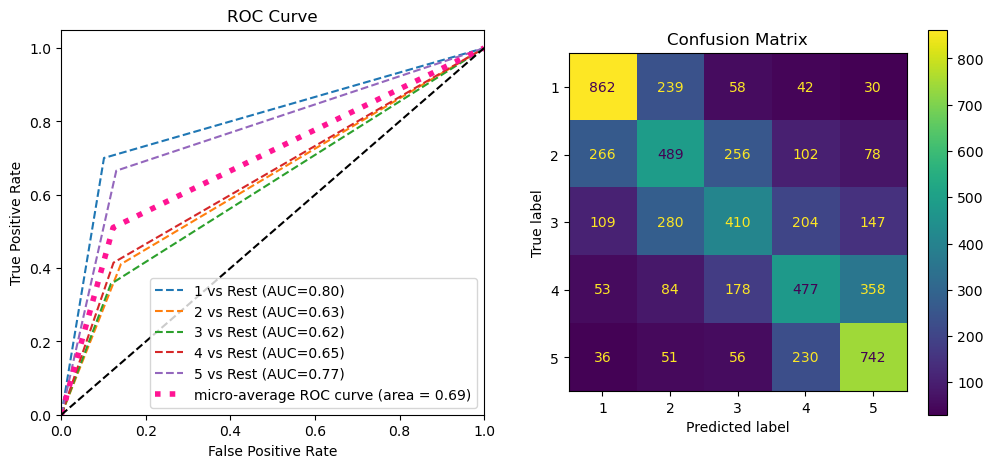

In [75]:
# Evaluation with train set and test sets
f1_log5, accuracy_log5, roc_score_log5 = model_evaluation(best_log5, X5_train, X5_test, y5_train, y5_test, True)

In [76]:
compare_data_5.append([str(best_log5), best_cv_log5, f1_log5, accuracy_log5, roc_score_log5])

#### Perceptron

In [77]:
# Hyperparamter tuning
best_perc5, best_cv_perc5 = hyperparameter_tuning("perceptron", X5, tags)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
---------------------------
Best model and hyperparameters: Perceptron(l1_ratio=0, max_iter=500, penalty='l2')
Best model's 5-fold cross-validation f1 macro: 0.35545011576756697
Mean 5-fold cross-validation F1 score: 0.3406655748900322
---------------------------


---------------------------
F1 score from testing: 0.38408171009962205
Accuracy from testing: 0.42590371766318313
---------------------------
ROC Curve and Confusion Matrix


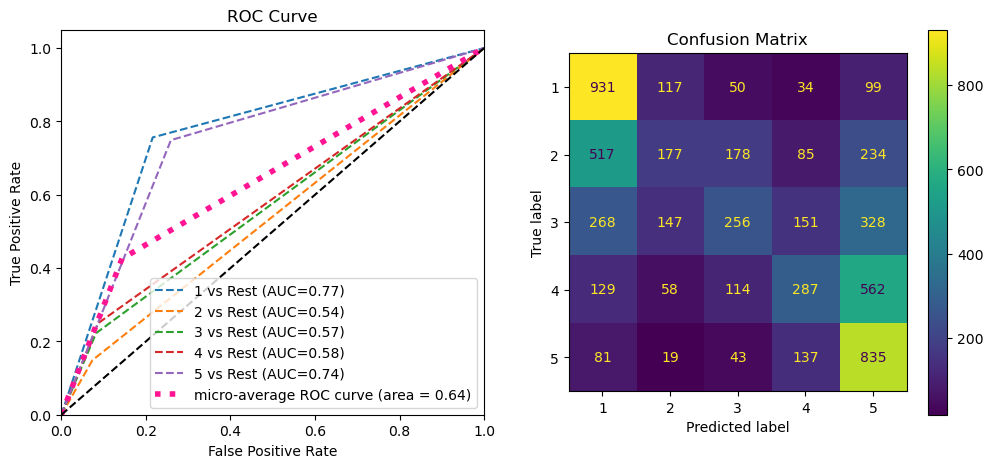

In [78]:
# Evaluation with train set and test sets
f1_perc5, accuracy_perc5, roc_score_perc5 = model_evaluation(best_perc5, X5_train, X5_test, y5_train, y5_test, True)

In [79]:
compare_data_5.append([str(best_perc5), best_cv_perc5, f1_perc5, accuracy_perc5, roc_score_perc5])

#### Multinomial Naive Bayes

In [80]:
# Hyperparamter tuning
best_nb5, best_cv_nb5 = hyperparameter_tuning("nb", X5, tags)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
---------------------------
Best model and hyperparameters: MultinomialNB(alpha=1)
Best model's 5-fold cross-validation f1 macro: 0.49234019507584187
Mean 5-fold cross-validation F1 score: 0.4700646585990053
---------------------------


---------------------------
F1 score from testing: 0.5001741094544376
Accuracy from testing: 0.5060818913825595
---------------------------
ROC Curve and Confusion Matrix


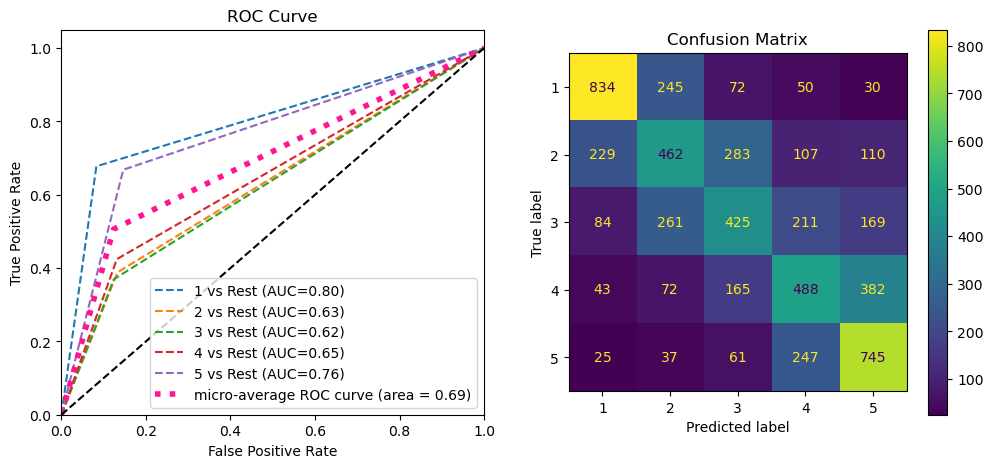

In [81]:
# Evaluation with train set and test sets
f1_nb5, accuracy_nb5, roc_score_nb5 = model_evaluation(best_nb5, X5_train, X5_test, y5_train, y5_test, True)

In [82]:
compare_data_5.append([str(best_nb5), best_cv_nb5, f1_nb5, accuracy_nb5, roc_score_nb5])

#### Compare performance

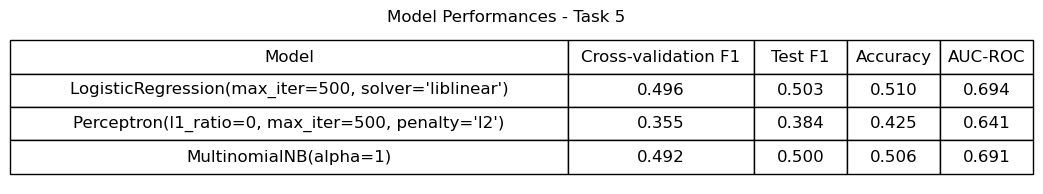

In [83]:
compare_table(compare_data_5, 5)

The top performers are Logistic Regression and Multinomial Naive Bayes, which yield pretty similar performance.

## 5. K-Means Clustering Task

In [3]:
# Import test data
data_test = pd.DataFrame(pd.read_csv("Test.csv"))

In [12]:
data_test['category'].unique()

array(['automotive', 'CDs', 'grocery', 'cell_phones', 'sports', 'toys'],
      dtype=object)

We can see that there are 6 product categories. The value for K should be pretty similar to this.

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import rand_score

In [5]:
# Import test data
data_test = pd.DataFrame(pd.read_csv("Test.csv"))

# Convert reviewText and summary to lower case
data_test.loc[:, 'reviewText'] = data_test['reviewText'].str.lower()
data_test.loc[:, 'summary'] = data_test['summary'].str.lower()

# Remove punctuations for reviewText and summary
data_test['reviewText']=data_test['reviewText'].str.replace('[^\w\s]','')
data_test['summary']=data_test['summary'].str.replace('[^\w\s]','')

In [87]:
# Vectorize reviewText and summary
vectorizer1 = TfidfVectorizer(stop_words = 'english', min_df = 0.1, max_features = 3000)
vectorizedReview_test = vectorizer1.fit_transform(data_test['reviewText']).toarray()

vectorizer2 = TfidfVectorizer(stop_words = 'english', min_df = 0.1, max_features = 2500)
vectorizedSummary_test = vectorizer2.fit_transform(data_test['summary'].values.astype('U')).toarray()

clusterFeature = np.concatenate((vectorizedReview_test, vectorizedSummary_test), axis =1)

In [90]:
# Plot the sum of squared distances for k values ranging from 1 to 100 to use the elbow method
Sum_of_squared_distances = []
K_range = range(1,101)
    
for num_clusters in K_range:
    kmeans = KMeans(n_clusters=num_clusters, max_iter = 500)
    kmeans.fit(clusterFeature)
    Sum_of_squared_distances.append(kmeans.inertia_)

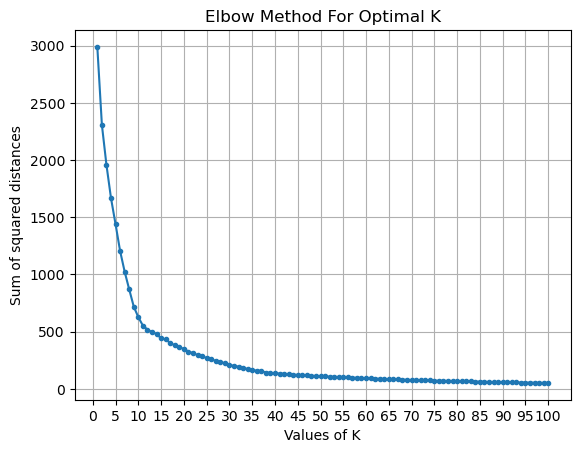

In [91]:
plt.plot(K_range,Sum_of_squared_distances, marker='o', markersize= 3)
plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances") 
plt.title("Elbow Method For Optimal K")
plt.xticks(np.arange(0,101,5))
plt.grid()
plt.show()

From the figure above, we see that the "elbow" occurs when k = 11. The elbow method tells us that this is the optimal K for this clustering task. This K value is very far from the number of product categories (6), meaning that the input features 'reviewText' and 'summary' might not correspond to the predefined product categories. It's also possible that the product categories have subcategories or nuances that the clustering algorithm is capturing, resulting in a higher number of clusters.

In [93]:
# Method to calculate silhoutte score and Rand index for the optimal k = 11
best_kmeans =  KMeans(n_clusters= 11, max_iter = 500)
best_kmeans.fit_predict(clusterFeature)
silhoutte = silhouette_score(clusterFeature, best_kmeans.labels_)
rand = rand_score(data_test["category"], best_kmeans.labels_)

print("The silhouette score is " + str(silhoutte))
print("The Rand index is " + str(rand))

The silhouette score is 0.66602239417106
The Rand index is 0.742350942184683
